In [5]:
import os

import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(10, 10)
plt.rcParams['font.family']='AppleGothic'

import warnings
warnings.filterwarnings(action='ignore')


### 1. 데이터 불러오기

In [6]:
def read_csv_by_dir(path, index_col=None):
    df_raw = pd.DataFrame()
    for files in os.listdir(path):
        if files.endswith('.csv'):
            df = pd.read_csv('/'.join([path, files]),
                            index_col=index_col)
        df_raw = pd.concat((df_raw,df),axis=0)
    return df_raw

In [7]:
path = 'data'
_df_rf_raw = read_csv_by_dir('/'.join([path, 'rf_data']),
                            index_col=0)

_df_water_raw = read_csv_by_dir('/'.join([path, 'water_data']),
                               index_col=0)

_submission_raw = pd.read_csv('/'.join([path, 'sample_submission.csv']),
                             index_col=0)

In [8]:
# raw_data 보존하기
df_rf=_df_rf_raw.copy()
df_rf.name = "rain_data"

df_water=_df_water_raw.copy()
df_water.name = "water_data"

submission=_submission_raw.copy()
submission.name = "submission"

### 2. 데이터 전처리

In [9]:
def index_to_datetime(df, format):
    df.index = pd.to_datetime(df.index,
                              format=format)
    return df

In [10]:
df_rf=index_to_datetime(df=df_rf, format='%Y-%m-%d %H:%M')
df_water=index_to_datetime(df=df_water, format='%Y-%m-%d %H:%M')
submission=index_to_datetime(df=submission, format='%Y-%m-%d %H:%M')

In [11]:
df_rf.sort_index(inplace=True)
df_water.sort_index(inplace=True)
submission.sort_index(inplace=True)

In [114]:
# 데이터 시간대 확인하기
def check_datetime(df):
    print(df.name)
    print(df.select_dtypes('datetime64[ns]').head(1).index[0])
    print(df.select_dtypes('datetime64[ns]').tail(1).index[0])
    return None
drop_data = df_water.drop(['sfw', 'swl', 'ecpc', 'inf', 'tototf', 'fw_1018662', 'fw_1018683', 'fw_1019630', 'fw_1018680'], axis=1)

check_datetime(df_rf)
check_datetime(df_water)
check_datetime(submission)
print(df_rf.columns)
print(df_water.columns)
print(submission.columns)
print(drop_data.columns)


rain_data
2012-05-01 00:00:00
2022-07-18 23:50:00
water_data
2012-05-01 00:00:00
2022-07-18 23:50:00
submission
2022-06-01 00:00:00
2022-07-18 23:50:00
Index(['rf_10184100', 'rf_10184110', 'rf_10184140'], dtype='object')
Index(['swl', 'inf', 'sfw', 'ecpc', 'tototf', 'tide_level', 'wl_1018662',
       'fw_1018662', 'wl_1018680', 'fw_1018680', 'wl_1018683', 'fw_1018683',
       'wl_1019630', 'fw_1019630'],
      dtype='object')
Index(['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630'], dtype='object')
Index(['tide_level', 'wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630'], dtype='object')


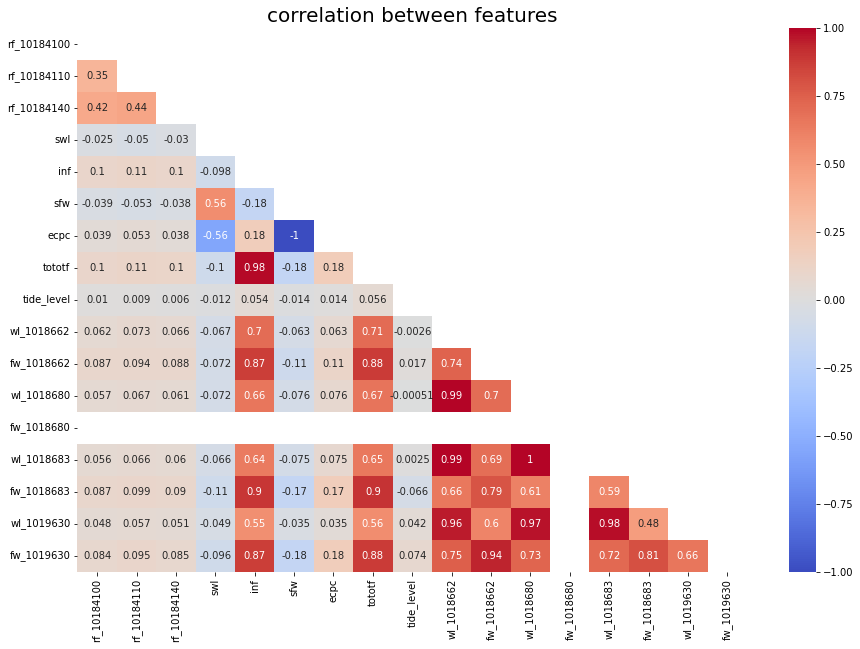

In [115]:
# data target 분리하기
target = df_water.loc[:, submission.columns]
check_corr_data = pd.concat((df_rf, df_water), axis=1)
data = pd.concat((df_rf, df_water.drop(submission.columns, axis=1)), axis=1)

import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
heat_table = check_corr_data.corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, mask = mask, cmap='coolwarm', vmin=-1, vmax=1)
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=10, rotation=90)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=10)
plt.title('correlation between features', fontsize=20)
plt.show()

In [116]:
check_corr_data.corrwith(check_corr_data['fw_1019630'])


rf_10184100    0.084289
rf_10184110    0.095275
rf_10184140    0.085152
swl           -0.095770
inf            0.873091
sfw           -0.176590
ecpc           0.176592
tototf         0.879145
tide_level     0.073854
wl_1018662     0.752340
fw_1018662     0.938739
wl_1018680     0.730169
fw_1018680          NaN
wl_1018683     0.718716
fw_1018683     0.805536
wl_1019630     0.661070
fw_1019630     1.000000
dtype: float64

In [117]:
# data와 target 하나 밀어주기 (과거데이터를 사용해야 함으로)
_target = target.reset_index(drop=True)
_data = data.reset_index(drop=True)

_data.index += 1

tot=pd.concat((_data, _target), axis=1)
tot=tot.sort_index()

tot=tot.iloc[1:-1]

target = tot.loc[:, submission.columns]
data = tot.drop(drop_data.columns, axis=1)



In [118]:
train_target=target.iloc[:-len(submission),:]
test_target=target.iloc[-len(submission):,:]

train_data=data.iloc[:-len(submission),:]
test_data=data.iloc[-len(submission):,:]

In [121]:
for these in [train_data, test_data]:
        these['swl'].fillna(these.groupby('sfw')['swl'].transform('mean'), inplace=True)
        these['inf'].fillna(these.groupby('tototf')['inf'].transform('mean'), inplace=True)
        these['sfw'].fillna(these.groupby('swl')['sfw'].transform('mean'), inplace=True)
        these['ecpc'].fillna(these.groupby('swl')['ecpc'].transform('mean'), inplace=True)
        these['tototf'].fillna(these.groupby('inf')['tototf'].transform('mean'), inplace=True)
        these['fw_1018662'].fillna(these.groupby('fw_1019630')['fw_1018662'].transform('mean'), inplace=True)
        these['fw_1018683'].fillna(these.groupby('tototf')['fw_1018683'].transform('mean'), inplace=True)
        these['fw_1019630'].fillna(these.groupby('fw_1018662')['fw_1019630'].transform('mean'), inplace=True)

In [120]:
# train_target.fillna(train_target.mean(), inplace=True)
# test_target.fillna(train_target.mean(), inplace=True)
# train_data.fillna(train_data.mean(), inplace=True)
# test_data.fillna(train_data.mean(), inplace=True)
# train_target.fillna(0, inplace=True)
# test_target.fillna(0, inplace=True)
# train_data.fillna(0, inplace=True)
# test_data.fillna(0, inplace=True)

In [133]:
print(train_target.head(15))

    wl_1018662  wl_1018680  wl_1018683  wl_1019630
1        314.7       300.2       290.0       275.3
2        313.7       301.2       290.0       275.3
3        311.7       301.2       290.0       276.3
4        311.7       301.2       291.0       277.3
5        311.7       301.2       291.0       277.3
6        312.7       301.2       291.0       277.3
7        311.7       301.2       291.0       277.3
8        312.7       301.2       291.0       278.3
9        312.7       301.2       291.0       278.3
10       311.7       301.2       291.0       278.3
11       312.7       301.2       291.0       278.3
12       312.7       301.2       291.0       278.3
13       312.7       301.2       291.0       278.3
14       312.7       301.2       291.0       278.3
15       312.7       301.2       291.0       278.3


In [122]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,MaxAbsScaler

# scaler = MinMaxScaler()
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = MaxAbsScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


In [123]:
print('--data--')
print(train_data.shape)
print(test_data.shape)
print('--target--')
print(train_target.shape)
print(test_target.shape)

--data--
(269423, 12)
(6912, 12)
--target--
(269423, 4)
(6912, 4)


### 3. modelling

In [125]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

kfold = KFold(n_splits=3, shuffle=True)
x_train, x_test, y_train, y_test = train_test_split(train_data, train_target, train_size=0.95, shuffle=True, random_state=42)  
rf = RandomForestRegressor(n_jobs=-1)

params = {
    "n_estimators" : (100, 150, 200, 250, 300, 400, 450, 500)
}

In [126]:
from sklearn.model_selection import GridSearchCV
grid_cv = GridSearchCV(rf,
                       param_grid=params,
                       cv = kfold,
                       n_jobs=-1)

#### GridSearchCV
###### GridSearchCV가 없다면 max_depth 가 3일때 가장 최적의 스코어를 뽑아내는지 1일때 가장 최적인 스코어를  뽑아내는지 일일이 학습을 해야 한다. 
###### 하지만 grid 파라미터 안에서 집합을 만들고 적용하면 최적화된 파라미터를 뽑아낼 수 있다.
###### -param_grid : 튜닝을 위해 파라미터, 사용될 파라미터를 dictionary 형태로 만들어서 넣는다.
###### -cv : 교차 검증에서 몇개로 분할되는지 지정한다.
###### -estimator : classifier, regressor, pipeline 등 가능
###### -scoring : 예측 성능을 측정할 평가 방법을 넣는다. 보통 accuracy 로 지정하여서 정확도로 성능 평가를 한다.
###### -refit : True가 디폴트로 True로 하면 최적의 하이퍼 파라미터를 찾아서 재학습 시킨다.

In [127]:
from tabnanny import verbose

# grid_cv.fit(train_data, train_target)
grid_cv.fit(x_train, y_train)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'n_estimators': (100, 150, 200, 250, 300, 400, 450,
                                          500)})

In [128]:
grid_cv.best_estimator_


RandomForestRegressor(n_estimators=450, n_jobs=-1)

In [129]:
from sklearn.metrics import r2_score, mean_squared_error

def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))



In [130]:

model = grid_cv.best_estimator_
# model.fit(train_data, train_target)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
r2 = r2_score(y_pred, y_test)
print('[r2_score]: ', r2)

rmse = RMSE(y_test, y_pred)
print('[RMSE]: ', rmse)

[r2_score]:  0.9977987653108018
[RMSE]:  2.93853131727866


In [131]:
y_pred = model.predict(test_data)
_submission_raw.iloc[:,:] = y_pred
_submission_raw.to_csv('save/ans.csv')